# Model 3 QCNN demonstration with Noisy Devices

# 1. Load Noisy Model with IBMQ

IBMQ Fake provider

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import data
import embedding

n_qubits = 4

In [2]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import IBMQ
from qiskit.providers.aer.backends import AerSimulator
from qiskit.providers.fake_provider import FakeJakarta, FakeMontreal
from qiskit_aer.noise import NoiseModel

IBMQ.load_account()
noisy = FakeJakarta()

noise_model = NoiseModel.from_backend(noisy)
coupling_map = noisy.configuration().coupling_map
basis_gates = noise_model.basis_gates

dev_fake = qml.device(
    'qiskit.aer',
    wires=n_qubits,
    shots=1024,
    noise_model=noise_model,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

Real Device (Skip below when using simulated noise model)

In [ ]:
TOKEN_tak = "798c4f141e8fa071c14823a956f816c8dda622f9f00b95cae62cc5b1a3105b4fe4845a234d661f20281f6b77ac0299e3c4367f6a3b58db16c36bcde3a9cb1151"
TOKEN_dkp = "3ae7ac10f40eb88c7ebb0eca20aa0788e7a96da729e2c3848d9864684362aaf50dfdda7cb3ec1ffd75eb7ed5b44f7c14f2f17419cf600ce14437ee7cd00ac75b"

IBMQ.save_account(token=TOKEN_dkp, overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-skku')
backend = "ibmq_jakarta"

dev_jakarta = qml.device(
    'qiskit.ibmq',
    wires=4,
    shots=1024,
    backend=backend,
    provider=provider
)

# 2. Feature Mapping Circuit

Create Feature Mapping Circuits. 

Note: This is 4 qubit feature mapping circuits used for demonstration.

Unlike noiseless simulation, last to first qubit CNOT gates are omitted for connectivity.

Also number of layers is set to 1 (N_layers = 3 for noiseless simulation).

In [3]:
# Quantum Embedding 2 for model 2
def Noisy_Four_QuantumEmbedding3(input):
    for j in range(4):
        qml.Hadamard(wires=j)
        embedding.exp_Z(input[j], wires=j)
    for k in range(3):
        embedding.exp_ZZ1(input[4+k], wires=[k, k+1])
    #exp_ZZ1(input[15], wires=[7,0])                        Removed for connectivity

def Noisy_Four_QuantumEmbedding3_inverse(input):
    #embedding.exp_ZZ1(input[15], wires=[7,0], inverse=True) Removed for connectivity
    for k in reversed(range(3)):
        embedding.exp_ZZ1(input[k+4], wires=[k,k+1], inverse=True)
    qml.Barrier()
    for j in range(4):
        embedding.exp_Z(input[j], wires=j, inverse=True)
        qml.Hadamard(wires=j)

Make Noisy_Model3_Fidelity 

In [4]:
import torch
from torch import nn

# Model3
@qml.qnode(dev_fake, interface="torch")
def circuit3(inputs): 
    Noisy_Four_QuantumEmbedding3(inputs[0:7])
    Noisy_Four_QuantumEmbedding3_inverse(inputs[7:14])
    return qml.probs(wires=range(4))

class Noisy_Model3_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(circuit3, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
        
    def forward(self, x1, x2):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x2 = self.layer1(x2)
        x2 = self.layer2(x2)
        x2 = x2.view(-1, 7 * 7)
        x2 = self.fc(x2)

        x = torch.concat([x1, x2], 1)
        x = self.qlayer3(x)
        return x[:,0]

Draw the circuit and check if everything is right

In [5]:
print("Circuit3: \n")
print(
    qml.draw(
        circuit3,
        expansion_strategy="device",
        show_matrices=False
    )([1,2,3,4,5,6,7,1,2,3,4,5,6,7])
)

Circuit3: 

0: ──H──RZ(-2.00)─╭●─────────────╭●───────────────────────────────────────────────────────────────
1: ──H──RZ(-4.00)─╰X──RZ(-10.00)─╰X─╭●─────────────╭●────────────────────────────────────╭●───────
2: ──H──RZ(-6.00)───────────────────╰X──RZ(-12.00)─╰X─╭●─────────────╭●─╭●────────────╭●─╰X───────
3: ──H──RZ(-8.00)─────────────────────────────────────╰X──RZ(-14.00)─╰X─╰X──RZ(14.00)─╰X──RZ(8.00)

────────────────╭●───────────────────╭●──RZ(2.00)──H─┤ ╭Probs
─────────────╭●─╰X─────────RZ(10.00)─╰X──RZ(4.00)──H─┤ ├Probs
───RZ(12.00)─╰X──RZ(6.00)──H─────────────────────────┤ ├Probs
───H─────────────────────────────────────────────────┤ ╰Probs


# 3. Load Datasets

In [6]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)

    X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
    if feature_reduction == False:
        X1_new = X1_new.permute(0, 3, 1, 2)
        X2_new = X2_new.permute(0, 3, 1, 2)
    return X1_new.to(device), X2_new.to(device), Y_new.to(device)

N_valid, N_test = 500, 1000
X1_new_valid, X2_new_valid, Y_new_valid = new_data(N_valid, X_test, Y_test)
X1_new_test, X2_new_test, Y_new_test = new_data(N_test, X_test, Y_test)

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/torch/csrc/utils/tensor_new.cpp:233.)
  


# 4. Train Models

Iterations: 0 Loss: 0.24524469673633575
Iterations: 10 Loss: 0.36811715364456177
Iterations: 20 Loss: 0.21873131394386292
Iterations: 30 Loss: 0.08410167694091797
Iterations: 40 Loss: 0.06948032230138779
Iterations: 50 Loss: 0.05171193927526474
Iterations: 60 Loss: 0.05985565111041069
Iterations: 70 Loss: 0.06232719495892525
Iterations: 80 Loss: 0.05515728145837784
Iterations: 90 Loss: 0.05828676372766495
Iterations: 100 Loss: 0.044550321996212006
Iterations: 110 Loss: 0.053519345819950104
Iterations: 120 Loss: 0.037641145288944244
Iterations: 130 Loss: 0.03900432586669922
Iterations: 140 Loss: 0.055387116968631744
Iterations: 150 Loss: 0.019077206030488014
Iterations: 160 Loss: 0.029794882982969284
Iterations: 170 Loss: 0.08827447891235352
Iterations: 180 Loss: 0.022861385717988014
Iterations: 190 Loss: 0.04988584667444229


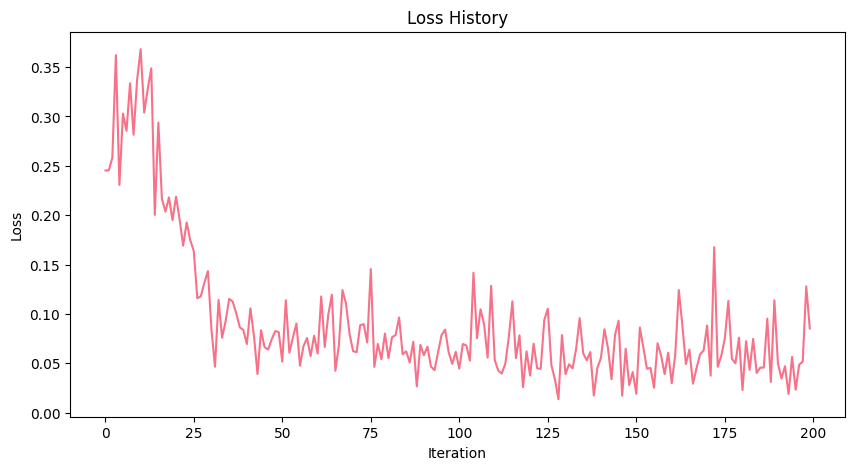

In [7]:
import seaborn as sns

def train_models(model_name):
    train_loss = []
    if model_name == 'Noisy_Model3_Fidelity':
        model = Noisy_Model3_Fidelity()
        PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Model 3/Noisy_Model3_Fidelity.pt'
    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(200):
        X1_batch, X2_batch, Y_batch = new_data(10, X_train, Y_train)
        X1_batch, X2_batch, Y_batch = X1_batch, X2_batch, Y_batch

        pred = model(X1_batch, X2_batch)
        pred, Y_batch = pred.to(torch.float32), Y_batch.to(torch.float32)
        loss = loss_fn(pred, Y_batch)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % 10 == 0:
            print(f"Iterations: {it} Loss: {loss.item()}")
    
    torch.save(model.state_dict(), PATH)

    plt.rcParams['figure.figsize'] = [10, 5]
    fig, ax = plt.subplots()
    clrs = sns.color_palette("husl", 1)
    with sns.axes_style("darkgrid"):
        ax.plot(range(len(train_loss)), train_loss, c=clrs[0])

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Loss History")

train_models('Noisy_Model3_Fidelity')

# 5. Check the distance after training

Separate the two classes of binary data

In [11]:
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)
X1_test, X0_test = X1_test.permute(0, 3, 1, 2), X0_test.permute(0, 3, 1, 2)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)
X1_train, X0_train = X1_train.permute(0, 3, 1, 2), X0_train.permute(0, 3, 1, 2)

Make trace distance measuring model

In [7]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev, interface="torch")
def Four_Distance3(inputs): 
    Noisy_Four_QuantumEmbedding3(inputs[0:7])
    return qml.density_matrix(wires=range(4))

class Distances_Model3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3_distance = qml.qnn.TorchLayer(Four_Distance3, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)

        
    def forward(self, x1, x0):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x0 = self.layer1(x0)
        x0 = self.layer2(x0)
        x0 = x0.view(-1, 7 * 7)
        x0 = self.fc(x0)

        rhos1 = self.qlayer3_distance(x1)
        rhos0 = self.qlayer3_distance(x0)
        
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))

PATH_Noisy_Model3 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Model 3/Noisy_Model3_Fidelity.pt'
D_Model3 = Distances_Model3()
D_Model3.load_state_dict(torch.load(PATH_Noisy_Model3))

<All keys matched successfully>

Trace Distance after Noisy_Model3_Fidelity

In [13]:
D_Model3_traindata = D_Model3(X1_train, X0_train)
D_Model3_testdata = D_Model3(X1_test, X0_test)
print(f"Trace Distance (Training Data) After Noisy Model3 Fidelity: {D_Model3_traindata}")
print(f"Trace Distance (Test Data) After Noisy Model3 Fidelity: {D_Model3_testdata}")

LB_Model3_traindata = 0.5 * (1 - D_Model3_traindata.detach().numpy())
print(f"Sample Loss lower bound after Noisy_Model3_Fidelity: {LB_Model3_traindata}")


/opt/anaconda3/envs/QC/lib/python3.7/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/aten/src/ATen/native/Copy.cpp:250.)
  return self.qnode(**kwargs).type(x.dtype)


Trace Distance (Training Data) After Noisy Model3 Fidelity: 0.8985708355903625
Trace Distance (Test Data) After Noisy Model3 Fidelity: 0.9057900905609131
Sample Loss lower bound after Noisy_Model3_Fidelity: 0.050714582204818726


# 6. Training QCNN

Re-Label the datasets

In [8]:
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [9]:
class x_transform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 8
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        return x.detach().numpy()

x_transform_Noisy_Model3_Fidelity = x_transform()
x_transform_Noisy_Model3_Fidelity.load_state_dict(torch.load(PATH_Noisy_Model3))

<All keys matched successfully>

Prepare QCNN circuit

In [10]:
def statepreparation(x):
    x = x_transform_Noisy_Model3_Fidelity(torch.tensor(x).to(torch.float32))
    Noisy_Four_QuantumEmbedding3(x[0])

def U_TTN(params, wires):  # 2 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

def QCNN_four(params):
    param1 = params[0:2]
    param2 = params[2:4]
    U_TTN(param1, wires=[0, 1])
    U_TTN(param1, wires=[2, 3])
    U_TTN(param1, wires=[1, 2])
    U_TTN(param1, wires=[3, 0])
    U_TTN(param2, wires=[0, 2])


@qml.qnode(dev_fake)
def QCNN_classifier(params, x):
    statepreparation(x)
    qml.Barrier()
    QCNN_four(params)
    return qml.expval(qml.PauliZ(2))

def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)

def cost(weights, X_batch, Y_batch):
    preds = [QCNN_classifier(weights, x) for x in X_batch]
    return Linear_Loss(Y_batch, preds)

steps = 400
learning_rate = 0.01
batch_size = 25
def circuit_training(X_train, Y_train):

    weights = np.random.random(4, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch),
                                                     weights)
        loss_history.append(cost_new)
        if it % 10 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, weights

Draw the circuit and check if everything is right

In [11]:
print(
    qml.draw(
        QCNN_classifier,
        expansion_strategy="device",
        show_matrices=False
    )(x=torch.ones(1,28,28), params=np.ones(4))
)

0: ──H──RZ(0.04)──╭●───────────╭●──RY(1.00)─────────────────────────╭●──────────RY(1.00)──────────
1: ──H──RZ(-1.59)─╰X──RZ(2.20)─╰X─╭●───────────────────╭●──RY(1.00)─╰X──────────RY(1.00)──────────
2: ──H──RZ(-1.00)─────────────────╰X─────────RZ(-1.32)─╰X─╭●───────────────────╭●─────────RY(1.00)
3: ──H──RZ(-1.37)─────────────────────────────────────────╰X─────────RZ(-3.39)─╰X─────────RY(1.00)

──────────────────╭X──RY(1.00)─╭●─┤     
───────────────╭●─│────────────│──┤     
──╭●──RY(1.00)─╰X─│───RY(1.00)─╰X─┤  <Z>
──╰X──RY(1.00)────╰●──────────────┤     


/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Train Noisy QCNN

In [12]:
loss_Noisy_Model3_Fidelity, weights_Noisy_Model3_Fidelity = circuit_training(X_train, Y_train)

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


iteration:  0  cost:  0.5446484375
iteration:  10  cost:  0.5295703125
iteration:  20  cost:  0.4934765625
iteration:  30  cost:  0.469375
iteration:  40  cost:  0.467265625
iteration:  50  cost:  0.435546875
iteration:  60  cost:  0.414921875
iteration:  70  cost:  0.4283203125
iteration:  80  cost:  0.4146484375
iteration:  90  cost:  0.4423828125
iteration:  100  cost:  0.430703125
iteration:  110  cost:  0.388515625
iteration:  120  cost:  0.4150390625
iteration:  130  cost:  0.380234375
iteration:  140  cost:  0.4365234375
iteration:  150  cost:  0.4095703125
iteration:  160  cost:  0.3531640625
iteration:  170  cost:  0.3984375
iteration:  180  cost:  0.3905859375
iteration:  190  cost:  0.4020703125
iteration:  200  cost:  0.3844921875
iteration:  210  cost:  0.4276171875
iteration:  220  cost:  0.4008984375
iteration:  230  cost:  0.4017578125
iteration:  240  cost:  0.39296875
iteration:  250  cost:  0.3535546875
iteration:  260  cost:  0.3903515625
iteration:  270  cost:  0.3

In [15]:
PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Model 3/'
f = open(PATH + 'loss_and_weight2_Noisy_Model3_Fidelity', 'w')
f.write('loss history: \n')
f.write(str(loss_Noisy_Model3_Fidelity))
f.write('\n')
f.write('weights: \n')
f.write(str(weights_Noisy_Model3_Fidelity))
f.close()

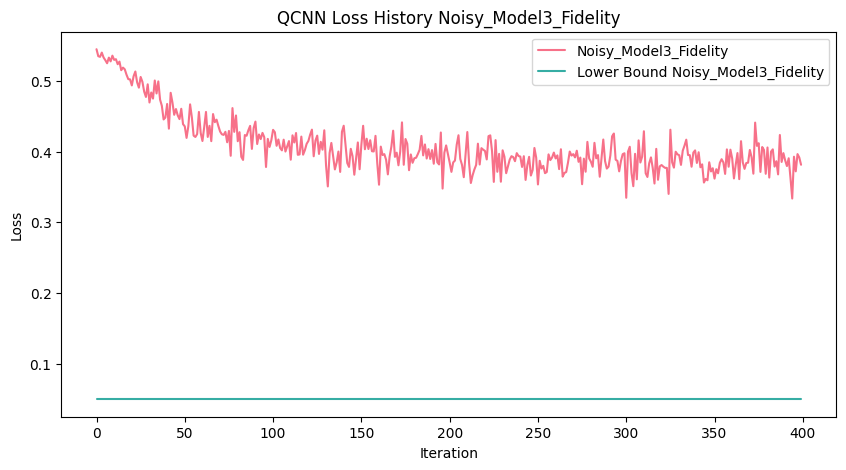

In [14]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 4)
with sns.axes_style("darkgrid"):
    ax.plot(range(len(loss_Noisy_Model3_Fidelity)), loss_Noisy_Model3_Fidelity, label="Noisy_Model3_Fidelity", c=clrs[0])
    ax.plot(range(400), np.ones(400) * 0.05, label="Lower Bound Noisy_Model3_Fidelity", c=clrs[2])


ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("QCNN Loss History Noisy_Model3_Fidelity")
ax.legend()

Check the classification accuracy

In [16]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)

predictions_Noisy_Model3_Fidelity = [QCNN_classifier(weights_Noisy_Model3_Fidelity, x) for x in X_test]
accuracy_Noisy_Model3_Fidelity = accuracy_test(predictions_Noisy_Model3_Fidelity, Y_test)
print(f" Accuracy after pre-training with Noisy_Model3_Fidelity: {accuracy_Noisy_Model3_Fidelity}")


/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Accuracy after pre-training with Noisy_Model3_Fidelity: 0.9040189125295508


# 7. Comparison with one fully connected hybrid networks.

In [17]:
weight_shapes = {"weights": (4)}
@qml.qnode(dev_fake)
def Hybrid_QCNN_circuit(inputs, weights):
    Noisy_Four_QuantumEmbedding3(inputs)
    QCNN_four(weights)
    return qml.expval(qml.PauliZ(2))


class Noisy_Hybrid_Model3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Layer1: 28 * 28 -> 14 * 14
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 8
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
        self.qcnn = qml.qnn.TorchLayer(Hybrid_QCNN_circuit, weight_shapes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        x = self.qcnn(x)
        return x

In [18]:
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [19]:
batch_size = 25

def train_noisy_hybrid_models(model_name):
    train_loss = []
    if model_name == 'Noisy_Hybrid_Model3':
        model = Noisy_Hybrid_Model3()
        PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Model 3/Noisy_Hybrid_Model3.pt'
    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(400):

        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]

        X_batch = torch.tensor(X_batch).to(torch.float32)
        Y_batch = torch.tensor(Y_batch).to(torch.float32)
        X_batch = X_batch.permute(0, 3, 1, 2)


        pred = model(X_batch)
        loss = loss_fn(pred, Y_batch)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % 10 == 0:
            print(f"Iterations: {it} Loss: {loss.item()}")
    
    torch.save(model.state_dict(), PATH)
    return train_loss

loss_Noisy_Hybrid_Model3 = train_noisy_hybrid_models('Noisy_Hybrid_Model3')

Iterations: 0 Loss: 1.015851616859436
Iterations: 10 Loss: 1.0120024681091309
Iterations: 20 Loss: 0.98409104347229
Iterations: 30 Loss: 1.0345138311386108
Iterations: 40 Loss: 0.9596143960952759
Iterations: 50 Loss: 0.9659913778305054
Iterations: 60 Loss: 0.9848445057868958
Iterations: 70 Loss: 0.8429782390594482
Iterations: 80 Loss: 0.8586534261703491
Iterations: 90 Loss: 0.8590344190597534
Iterations: 100 Loss: 0.7579850554466248
Iterations: 110 Loss: 0.6336831450462341
Iterations: 120 Loss: 0.8290286064147949
Iterations: 130 Loss: 0.6474122405052185
Iterations: 140 Loss: 0.6935165524482727
Iterations: 150 Loss: 0.5735642910003662
Iterations: 160 Loss: 0.55409836769104
Iterations: 170 Loss: 0.49912598729133606
Iterations: 180 Loss: 0.5010343790054321
Iterations: 190 Loss: 0.4215109348297119
Iterations: 200 Loss: 0.37899094820022583
Iterations: 210 Loss: 0.3768157958984375
Iterations: 220 Loss: 0.4002934396266937
Iterations: 230 Loss: 0.38764190673828125
Iterations: 240 Loss: 0.35695

Check classification accuracy of Noisy Hybrid Model3

In [21]:
X_test = [X_train[i] for i in range(len(X_test))]
Y_test = [Y_train[i] for i in range(len(Y_test))]

X_test = torch.tensor(X_test).to(torch.float32)
Y_test = torch.tensor(Y_test).to(torch.float32)
X_test = X_test.permute(0, 3, 1, 2)

In [27]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        p = p.detach()
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)

In [28]:
Trained_Noisy_Hybrid_Model3 = Noisy_Hybrid_Model3()
Trained_Noisy_Hybrid_Model3.load_state_dict(torch.load('/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Model 3/Noisy_Hybrid_Model3.pt'))

predictions_Noisy_Hybrid_Model3 = [Trained_Noisy_Hybrid_Model3(x) for x in X_test]
accuracy_Noisy_Hybrid_Model3 = accuracy_test(predictions_Noisy_Hybrid_Model3, Y_test)
print(f" Accuracy with Noisy_Hybrid_Model3: {accuracy_Noisy_Hybrid_Model3}")

 Accuracy with Noisy_Hybrid_Model3: 0.9957446808510638


Compare Classification Accuracy

In [29]:
print(f" Accuracy after pre-training with Noisy_Model3_Fidelity: {accuracy_Noisy_Model3_Fidelity}")
print(f" Accuracy with Noisy_Hybrid_Model3: {accuracy_Noisy_Hybrid_Model3}")

 Accuracy after pre-training with Noisy_Model3_Fidelity: 0.9040189125295508
 Accuracy with Noisy_Hybrid_Model3: 0.9957446808510638
